# Синтез управления ЛА на основе методов МО.
Данный проект представляет собой попытку синтеза закона управления ЛА на основе подхода обучения с подкреплением. Закон управления будет выполнен путём наблюдения отклика динамической системы на случайные воздействия.

Автор: Саразова Е.М.

2022 год.

In [1]:
# Загрузка необходимых библиотек.
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
import h5py
from scipy.integrate import odeint
from matplotlib.colors import ListedColormap
from ipywidgets import IntProgress
from IPython.display import display
from datetime import datetime

In [2]:
# Блок предварительной настройки.
# Отключаем все возможные предупреждения.
warnings.filterwarnings("ignore")

# Принудительно отключаем функции второй версии.
tf.disable_v2_behavior()

# Настройки для графиков.
plt.rcParams.update({
        "axes.facecolor"       : "White",
        "axes.labelsize"       : 14,
        "axes.titlesize"       : 16,
        "axes.grid"            : True,
        "axes.grid.axis"       : "both",
        "grid.linestyle"       : "dotted",
        "grid.alpha"           : 0.75,
        "legend.facecolor"     : "Lavender",
        "legend.shadow"        : True,
        "legend.fontsize"      : 16,
        "legend.edgecolor"     : "black",
        "legend.title_fontsize": 16,
        "figure.facecolor"     : "Lavender",
        "xtick.labelsize"      : 16,
        "ytick.labelsize"      : 16,
        "font.size"            : 16
    })

# Подготавливаем имя журнала.
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "Buran_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# Блок фукнций.
def discount_rewards(rewards, discount_rate):
    '''
    Функция расчёта награды с учётом дисконтной ставки для отдельного шага.
    '''
    
    discounted_rewards = np.empty(len(rewards)) # Выделяем место под награды.
    cumulative_rewards = 0                      # Инициализация суммарных наград.
    
    # Делаем расчёт награды с учётом дисконта для отдельного шага.
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards*discount_rate # Суммарная награда для шага.
        discounted_rewards[step] = cumulative_rewards                         # Обновляем награду.
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    '''
    Функция нормализации массива наград с учётом дисконта.
    '''
    
    # Делаем расчёт наград с учётом дисконта для всех шагов.
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards) # Объединяем в один массив.
    reward_mean = flat_rewards.mean()                     # Вычисляем среднее массива.
    reward_std = flat_rewards.std()                       # Вычисляем СКО.
    
    # Возвращаем нормализированные награды.
    return [(discounted_rewards-reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]


def model(x, t, u, w, k):
    '''
    Функция расчёта производных для решения ОДУ.
    '''
    
    dx1dt =  w*x[1] + k*u[0] # Первая производная.
    dx2dt = -w*x[0] + k*u[1] # Вторая производная.
    dzdt = [dx1dt, dx2dt]    # Объединяем в один массив.
    return dzdt

def agent_env(action, w, k, x1, x2, t):
    '''
    Функция взаимодействия среды и агента.
    '''
    # На основе выбранного агентом действия происходит выбор управления.
    u = -np.ones(2) # Первое действие.
    if action == 1: # Второе действие.
        u[0] = -1
        u[1] =  1
    if action == 2: # Третье действие.
        u[0] = 1
        u[1] = 1
    if action == 3: # Четвёртое действие.
        u[0] =  1
        u[1] = -1
        
    # Решаем ОДУ для нового шага.
    result = odeint(model, [x1, x2], t, args=(u, w, k))
    
    result = np.array([result[1][0], result[1][1]]) # Выбираем новую точку.
    r2 = result[0]**2 + result[1]**2                # Расчёт квадрата "расстояния".
    reward = -r2**P                                 # Вычисляем награду.
    
    done = False    # Флаг стабилизации системы.
    if r2 < 1.0e-3: # Система стабилизировалась?
        done=True   # Завершаем игру.
        
    # Возвращаем новые признаки, награду и признак завершения игры.
    return np.hstack([result, np.array([-reward])]), reward, done

def optimal_u(w, k, x1, x2):
    '''
    Функция расчёта оптимального управления.
    '''
    
    # Блок расчёта вспомогательных переменных.
    wx1 = w*x1
    wx2 = w*x2
    j1=int(np.abs(wx1)/2.0)
    j2=int(np.abs(wx2)/2.0)
    
    # Блок синтеза оптимального управления.
    u = np.ones(2)
    if wx1<0 and wx2<=0 :
        if (wx1-k)**2+(wx2+(2*j2+1)*k)**2 < 2*k**2 :
            u[0] = -1
    elif wx1<0 and wx2>0 :
        if (wx1+(2*j1+1)*k)**2+(wx2+k)**2 > 2*k**2 :
            u[1] = -1
    elif wx1>0 and wx2>0 :
        u[1] = -1
        if (wx1+k)**2+(wx2-(2*j2+1)*k)**2 > 2*k**2 :
            u[0] = -1
    else:
        u[0] = -1
        if (wx1-(2*j1+1)*k)**2+(wx2-k)**2 < 2*k**2 :
            u[1] = -1
    return u

def optimal_agent_env(w, k, x1, x2, t):
    '''
    Функция расчёта взаимодействия среды и агента в случае оптимального управления.
    '''
    
    u = optimal_u(w, k, x1, x2)                         # Расчёт оптимального управления.
    result = odeint(model, [x1, x2], t, args=(u, w, k)) # Решение ОДУ.
    return result

def opt_solve(w, k, x1_init, x2_init, t):
    '''
    Функция расчёта оптимальной траектории.
    '''
    
    x  = [x1_init, x2_init] # Вектор начальных значений.
    x1 = np.zeros_like(t)   # Выделеям место под вектор решения.
    x2 = np.zeros_like(t)   # Выделеям место под вектор решения.
    
    x1[0] = x[0] # Обновляем информацию.
    x2[0] = x[1] # Обновляем информацию.
    ind = 0      # Индекс времени стабилизации.
    
    # Расчёт оптимальной траектории.
    for i in range(1, len(t)):
        tspan = [t[i-1],t[i]] # Выбираем временной шаг.
        # Получаем новое решение.
        result = optimal_agent_env(w, k, x1[i-1], x2[i-1], tspan)
        # Обновляем данные.
        ind += 1
        x1[i] = result[1][0]
        x2[i] = result[1][1]
        x = result[1]
        
        # Проверяем стабилизировалась ли система.
        if x[0]**2+x[1]**2<1.e-3:
            break    
    return x1, x2, ind

def GammaLines(w, k, a):
    '''
    Функция расчёта gamma линий.
    '''
    
    wcount = w * a                        # ~Количество циклов.
    wx1 = np.linspace(-wcount, 0.0, 1000) # Инициализация первой переменной.
    wx2 = np.zeros_like(wx1)              # Инициализация второй переменной.
    
    # Расчёт координат точек.
    for i in range(len(wx1)):
        index = np.abs(np.ceil(wx1[i]/2))
        wx2[i] = (2-(wx1[i]+2*index+1)**2)**0.5-1
    return wx1, wx2

In [4]:
# Блок начальной инициализации переменных.

# Инициализация переменных среды.
X_INIT = 2   # Инициализация X1.
Y_INIT = 2   # Инициализация X2.
W_INIT = 0.5 # Инициализация W.
K = 1        # Инициализация K.

# Инициализация переменных нейронной сети.
n_inputs = 3    # Количество входов.
n_hidden_0 = 40 # Количество нейроной 1 скрытого слоя.
n_hidden_1 = 30 # Количество нейроной 2 скрытого слоя.
n_hidden_2 = 20 # Количество нейроной 3 скрытого слоя.
n_hidden_3 = 10 # Количество нейроной 4 скрытого слоя.
n_outputs = 4   # Количество выходов.

# Инициализация переменных этапа обучения.
P = 0.5                # Параметр для штрафа.
learning_rate = 0.0005  # Скорость обучения.

In [5]:
# Архитектура и построение нейронной сети.
# Инициализация весов нейронной сети.
initializer = tf.variance_scaling_initializer()

# Строим нейронную сеть.
X = tf.placeholder(tf.float32, shape=[None, n_inputs]) # Вектор заполнитель.
hidden_0 = tf.layers.dense(X, n_hidden_0, activation=tf.nn.elu, kernel_initializer=initializer)        # Вход.
hidden_1 = tf.layers.dense(hidden_0, n_hidden_1, activation=tf.nn.elu, kernel_initializer=initializer) # Первый скрытый слой.
hidden_2 = tf.layers.dense(hidden_1, n_hidden_2, activation=tf.nn.elu, kernel_initializer=initializer) # Второй скрытый слой.
hidden_3 = tf.layers.dense(hidden_2, n_hidden_3, activation=tf.nn.elu, kernel_initializer=initializer) # Третий скрытый слой.
logits = tf.layers.dense(hidden_3, n_outputs, kernel_initializer=initializer)                          # Выход.

outputs = tf.nn.softmax(logits) # Прогноз нейронной сети.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [6]:
# Случайное действие.
action = tf.multinomial(tf.log(outputs), num_samples=1)

Instructions for updating:
Use `tf.random.categorical` instead.


In [7]:
y = action[0] # Выбор логитов.

In [8]:
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits) # Функция потерь.
optimizer = tf.train.AdamOptimizer(learning_rate)                                       # Выбор оптимизатора.
grads_and_vars = optimizer.compute_gradients(cross_entropy)                             # Расчёт градиентов.

In [9]:
gradients = [grad for grad, variable in grads_and_vars] # Выделяем лишь градиенты.

In [10]:
# Блок расчёта градиентов по нескольким играм.
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))

training_op = optimizer.apply_gradients(grads_and_vars_feed) # Тензор для оптимизатора.
init = tf.global_variables_initializer()                     # Инициализация всех глобальных переменных.
saver = tf.train.Saver()                                     # Берём ссылку на текущую нейронную сеть.

In [11]:
# Блок создания журанла мониторинга.
ce_placeholder = tf.placeholder(tf.float32, shape=(None, 1))
CROSS_ENTROPY_ = tf.reduce_mean(ce_placeholder, name= 'CROSS_ENTROPY_')
CROSS_ENTROPY = tf.summary.scalar ('CROSS_ENTROPY', CROSS_ENTROPY_ )
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [12]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

In [13]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

.
Iteration: 0

W=8.5

Optimal Control Время: 2.015335889314886

Neural Net Время: 29.994999166527755

Начальная точка (+): -1.8859513131765384, 1.7742817002458833

Конечная точка (*): -1.1797096638729456, -1.624939295634981

Начальное Расстояние - 2.589379830673695

Конечное Расстояние - 2.0080195729957233


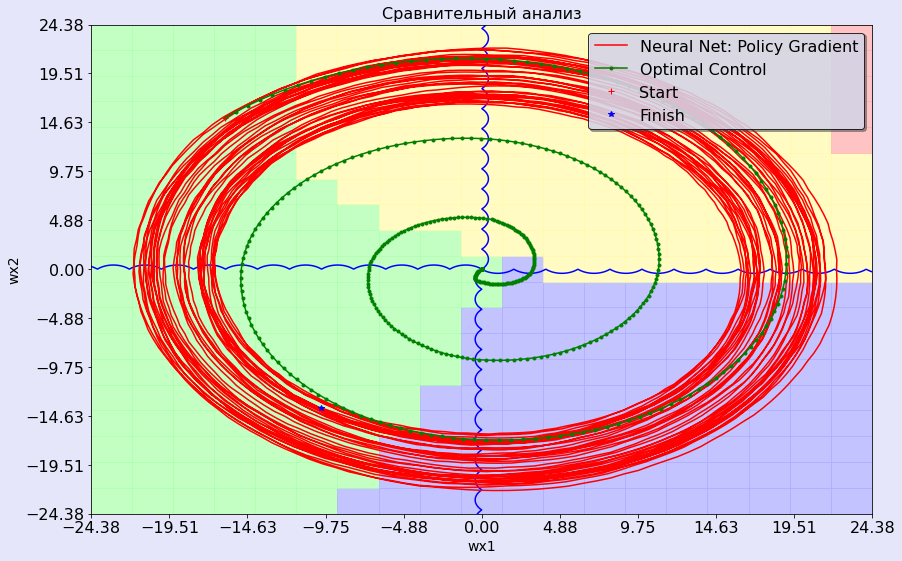

Instructions for updating:
Use standard file APIs to delete files with this prefix.
..................................................
Iteration: 100

W=8.0

Optimal Control Время: 1.1251875312552093

Neural Net Время: 4.965827637939657

Начальная точка (+): 1.4119636113351781, -0.40433973498353293

Конечная точка (*): 0.0, 0.0

Начальное Расстояние - 1.4687177608448914

Конечное Расстояние - 0.0


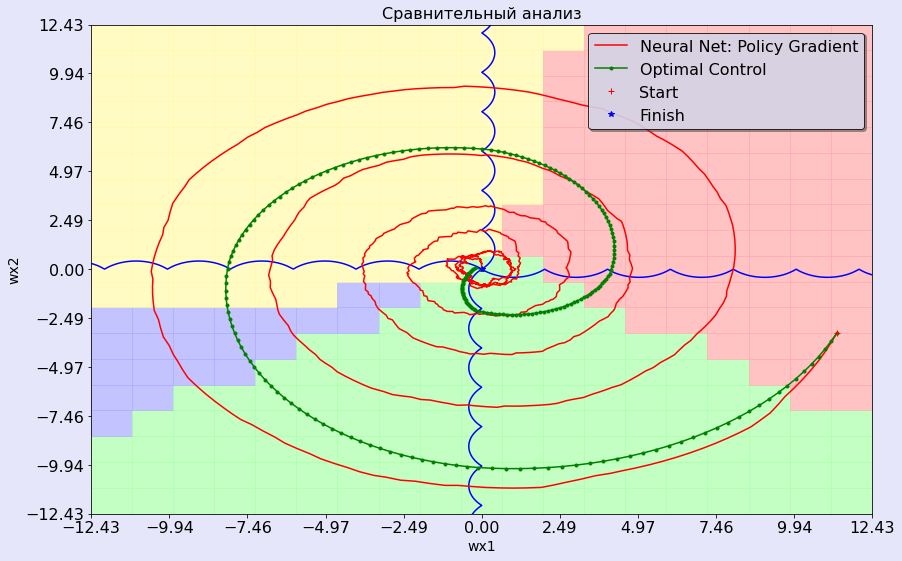

....................................................................................................
Iteration: 200

W=9.0

Optimal Control Время: 0.8351391898649775

Neural Net Время: 3.0655109184864147

Начальная точка (+): -0.15883704875524796, 1.0798202214224135

Конечная точка (*): 0.0, 0.0

Начальное Расстояние - 1.0914398373937186

Конечное Расстояние - 0.0


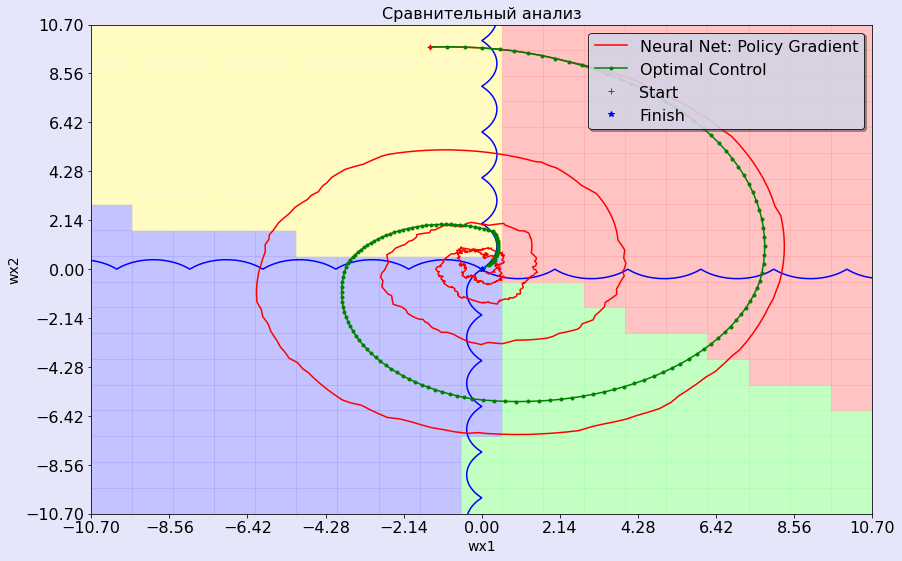

....................................................................................................
Iteration: 300

W=6.5

Optimal Control Время: 0.9101516919486582

Neural Net Время: 2.8404734122353728

Начальная точка (+): -0.5152939928250979, -1.0621920546940675

Конечная точка (*): 0.0, 0.0

Начальное Расстояние - 1.1805845416982372

Конечное Расстояние - 0.0


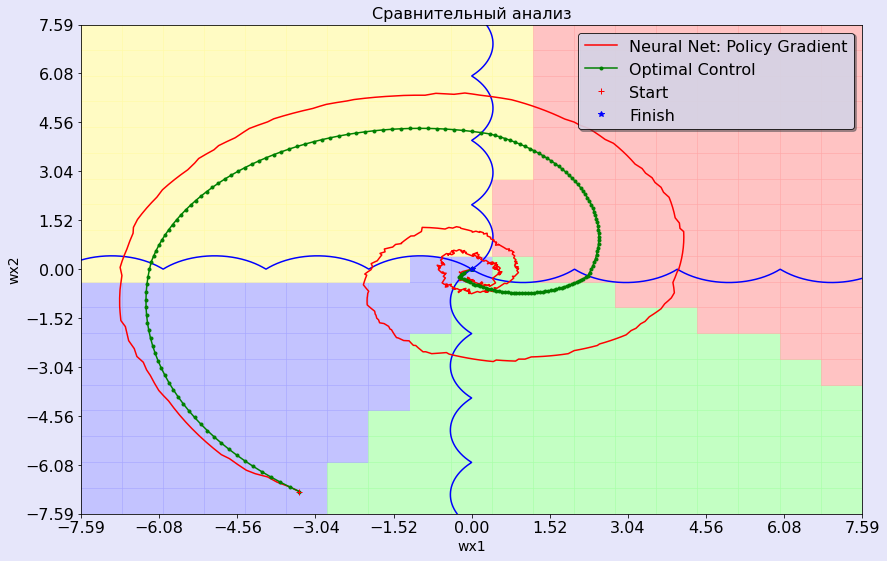

....................................................................................................
Iteration: 400

W=5.0

Optimal Control Время: 0.7251208534755793

Neural Net Время: 1.4702450408401402

Начальная точка (+): -0.4250131223071816, 0.8305520209238364

Конечная точка (*): 0.0, 0.0

Начальное Расстояние - 0.9329806072979052

Конечное Расстояние - 0.0


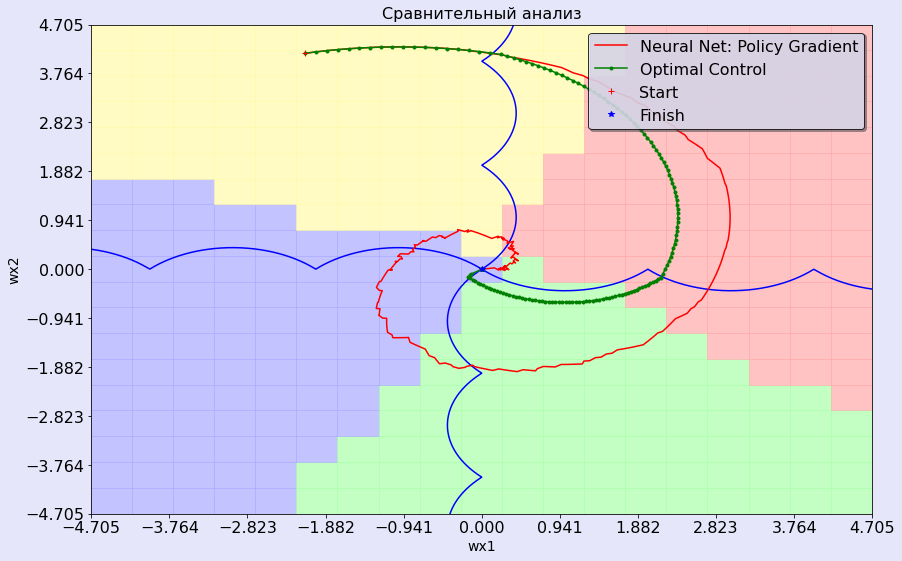

....................................................................................................
Iteration: 500

W=6.0

Optimal Control Время: 1.2902150358393065

Neural Net Время: 1.93532255375896

Начальная точка (+): -1.2560453182848836, 1.095367370728456

Конечная точка (*): 0.0, 0.0

Начальное Расстояние - 1.6665771864639047

Конечное Расстояние - 0.0


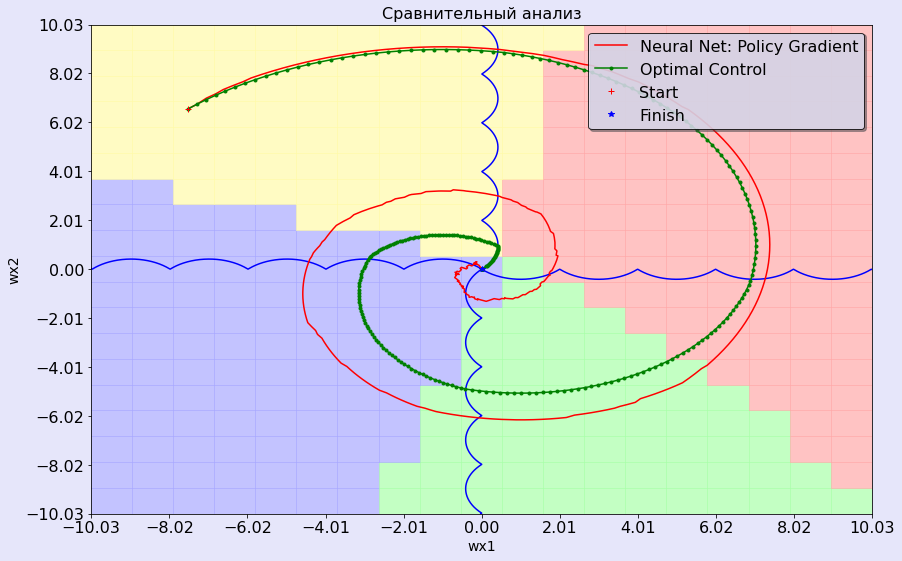

....................................................................................................
Iteration: 600

W=5.5

Optimal Control Время: 0.9451575262543758

Neural Net Время: 1.6502750458409736

Начальная точка (+): 1.2117826655429682, 0.0878673368098779

Конечная точка (*): 0.0, 0.0

Начальное Расстояние - 1.2149641547751446

Конечное Расстояние - 0.0


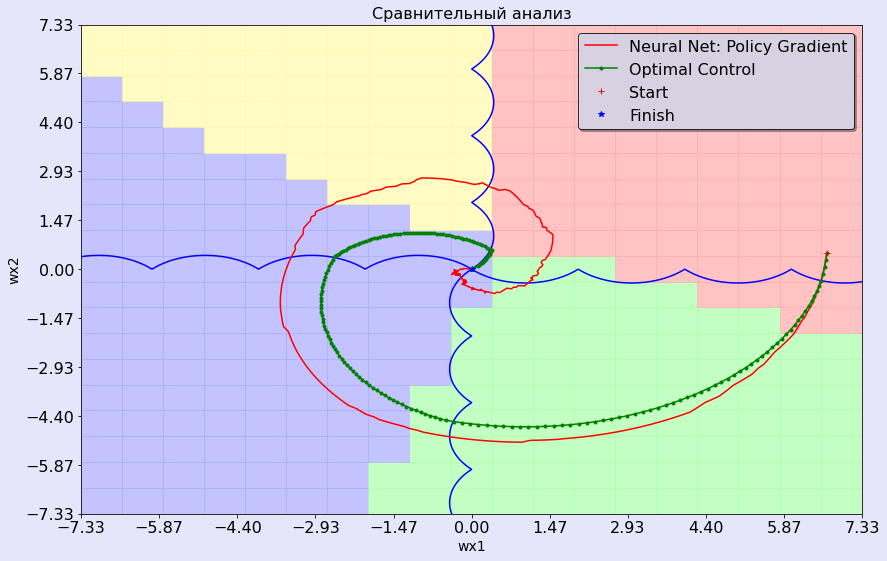

....................................................................................................
Iteration: 700

W=5.0

Optimal Control Время: 0.9901650275045841

Neural Net Время: 2.150358393065511

Начальная точка (+): -1.2531667957153108, 0.25886914705268405

Конечная точка (*): 0.0, 0.0

Начальное Расстояние - 1.279625043979354

Конечное Расстояние - 0.0


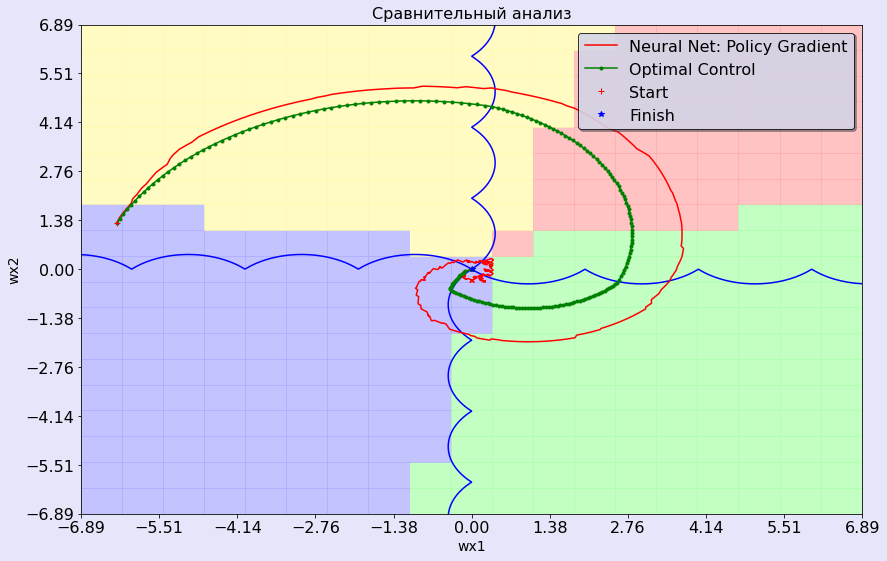

....................................................................................................
Iteration: 800

W=1.0

Optimal Control Время: 1.575262543757293

Neural Net Время: 2.0403400566761127

Начальная точка (+): 1.7847343400693152, 0.9824406932407093

Конечная точка (*): 0.0, 0.0

Начальное Расстояние - 2.0372693440873104

Конечное Расстояние - 0.0


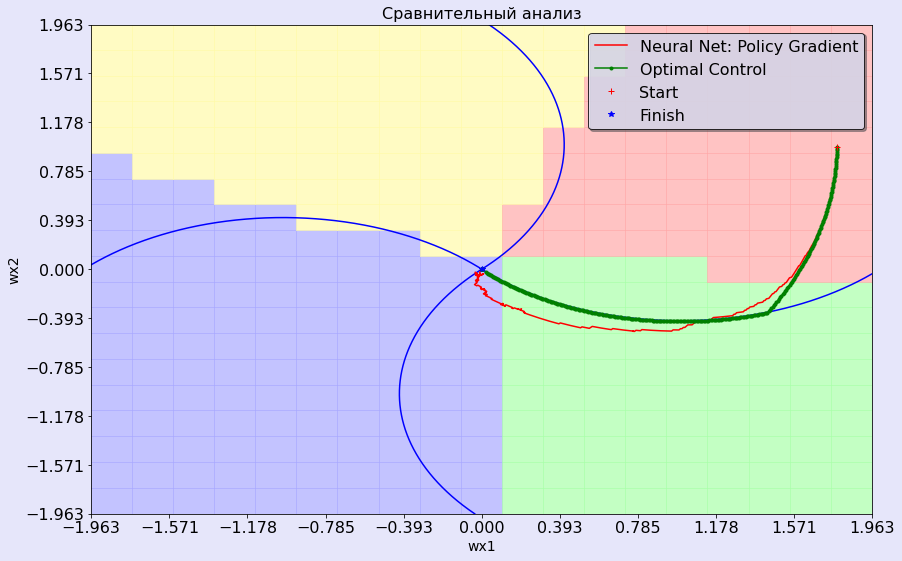

....................................................................................................
Iteration: 900

W=2.0

Optimal Control Время: 0.6701116852808802

Neural Net Время: 0.9251541923653943

Начальная точка (+): 0.7268426270640802, 0.4632699521960668

Конечная точка (*): 0.0, 0.0

Начальное Расстояние - 0.8619276379866001

Конечное Расстояние - 0.0


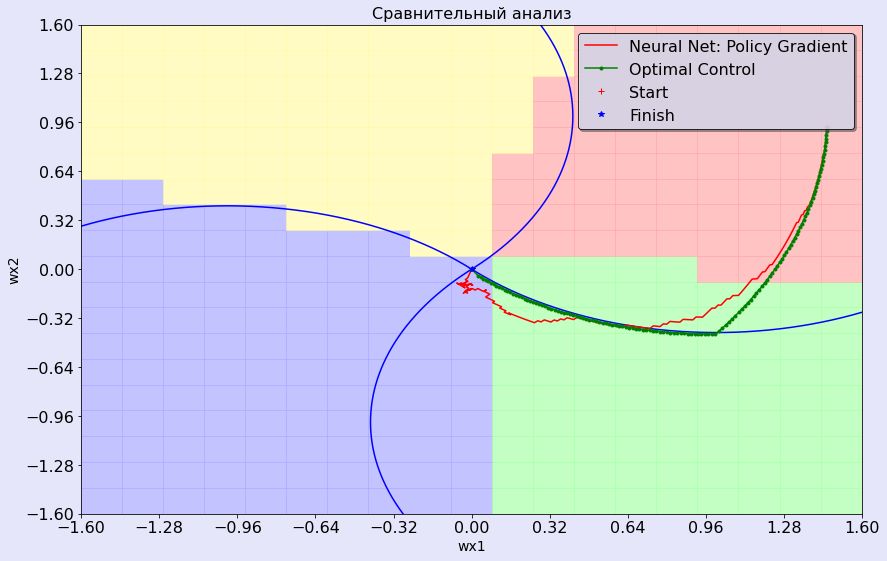

....................................................................................................
Iteration: 1000

W=2.5

Optimal Control Время: 1.1201866977829638

Neural Net Время: 2.0103350558426407

Начальная точка (+): 1.2869857287141007, 0.6417663652907484

Конечная точка (*): 0.0, 0.0

Начальное Расстояние - 1.4381225029642861

Конечное Расстояние - 0.0


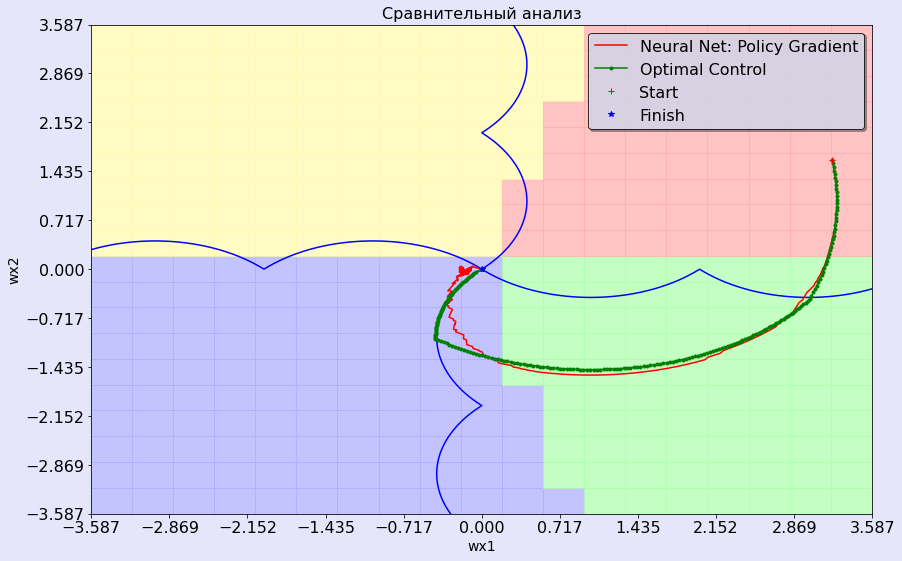

....................................................................................................
Iteration: 1100

W=1.0

Optimal Control Время: 1.575262543757293

Neural Net Время: 2.3803967327887983

Начальная точка (+): 1.962324706436942, 0.5262486781514264

Конечная точка (*): 0.0, 0.0

Начальное Расстояние - 2.0316633394214096

Конечное Расстояние - 0.0


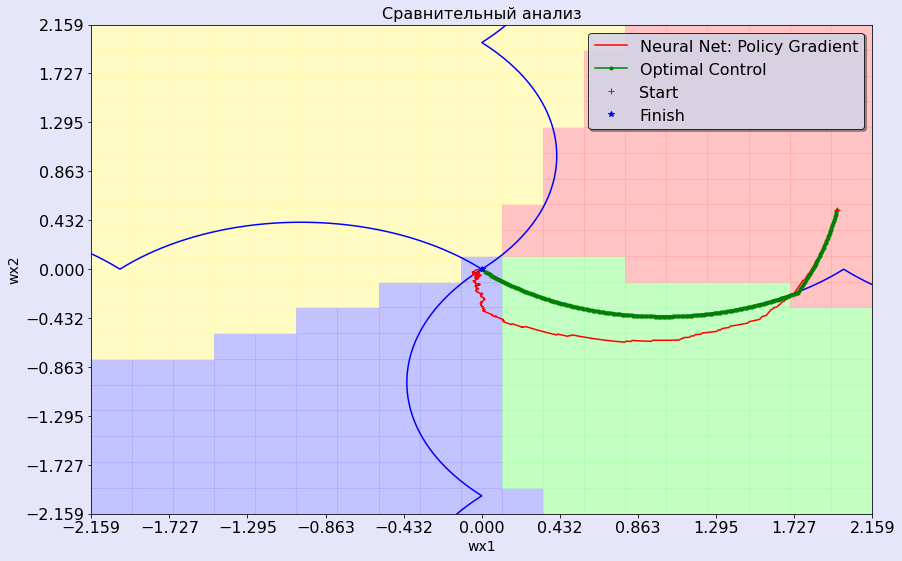

....................................................................................................
Iteration: 1200

W=2.5

Optimal Control Время: 1.0601766961160193

Neural Net Время: 1.415235872645441

Начальная точка (+): 1.3185924504902244, -0.4773886926636681

Конечная точка (*): 0.0, 0.0

Начальное Расстояние - 1.4023501753745178

Конечное Расстояние - 0.0


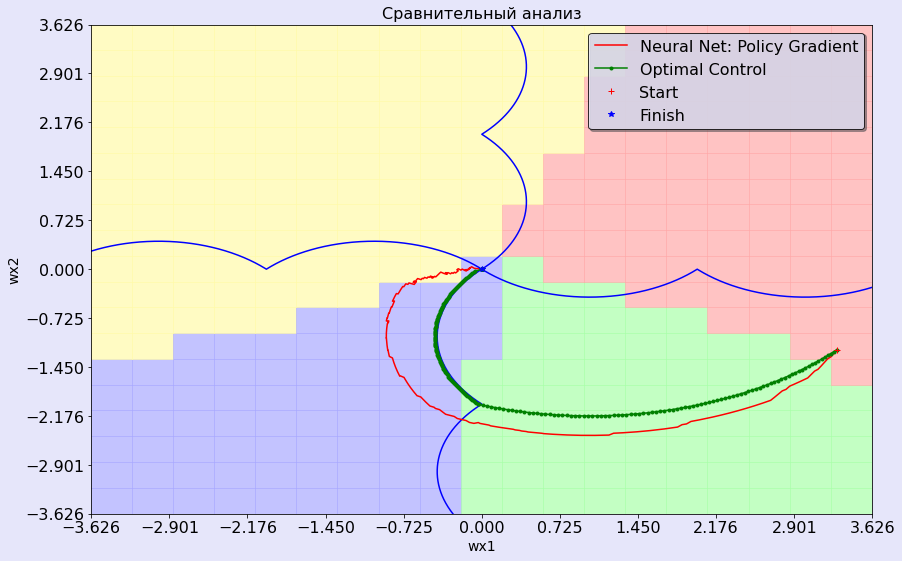

....................................................................................................
Iteration: 1300

W=1.0

Optimal Control Время: 1.1651941990331722

Neural Net Время: 1.8653108851475246

Начальная точка (+): -1.1328971792130051, 0.9464461084018998

Конечная точка (*): 0.0, 0.0

Начальное Расстояние - 1.4762168725420681

Конечное Расстояние - 0.0


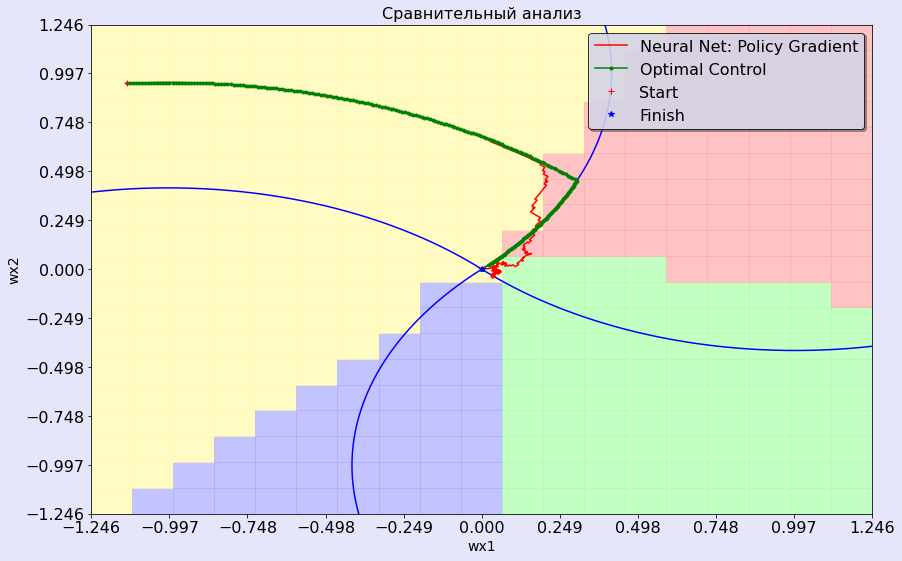

....................................................................................................
Iteration: 1400

W=2.0

Optimal Control Время: 1.2502083680613436

Neural Net Время: 1.4752458743123855

Начальная точка (+): -0.3025947633612329, 1.5621431740665948

Конечная точка (*): 0.0, 0.0

Начальное Расстояние - 1.5911803439888565

Конечное Расстояние - 0.0


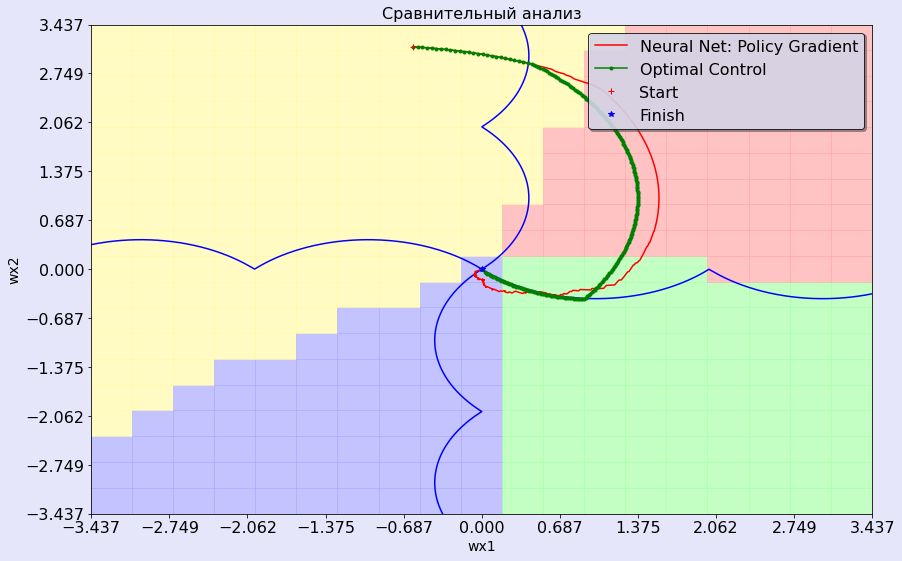

....................................................................................................
Iteration: 1500

W=8.0

Optimal Control Время: 1.5002500416736124

Neural Net Время: 1.7852975495915986

Начальная точка (+): 0.3903210575996532, 1.9070241388925568

Конечная точка (*): 0.0, 0.0

Начальное Расстояние - 1.9465589110850485

Конечное Расстояние - 0.0


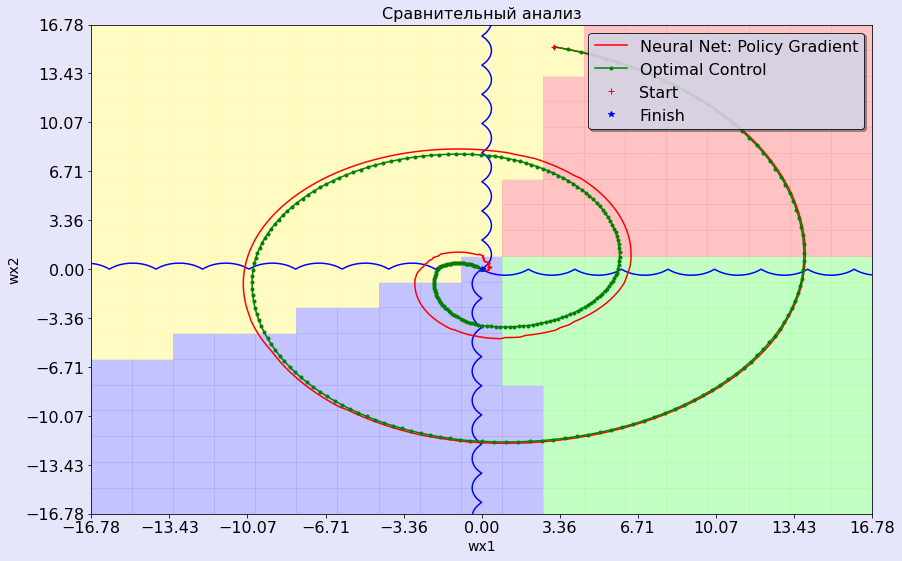

....................................................................................................
Iteration: 1600

W=3.0

Optimal Control Время: 1.3052175362560428

Neural Net Время: 1.5802633772295382

Начальная точка (+): -1.1048183760318917, 1.2523004867329606

Конечная точка (*): 0.0, 0.0

Начальное Расстояние - 1.6699940578006127

Конечное Расстояние - 0.0


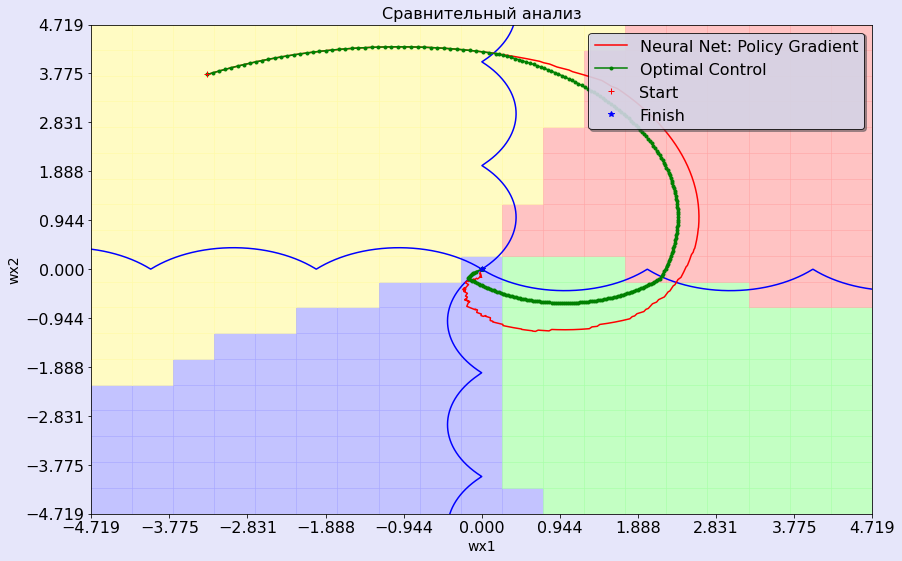

....................................................................................................
Iteration: 1700

W=4.5

Optimal Control Время: 1.2052008668111351

Neural Net Время: 1.630271711951992

Начальная точка (+): -0.7078974351856839, 1.3666991368266537

Конечная точка (*): 0.0, 0.0

Начальное Расстояние - 1.5391508403484013

Конечное Расстояние - 0.0


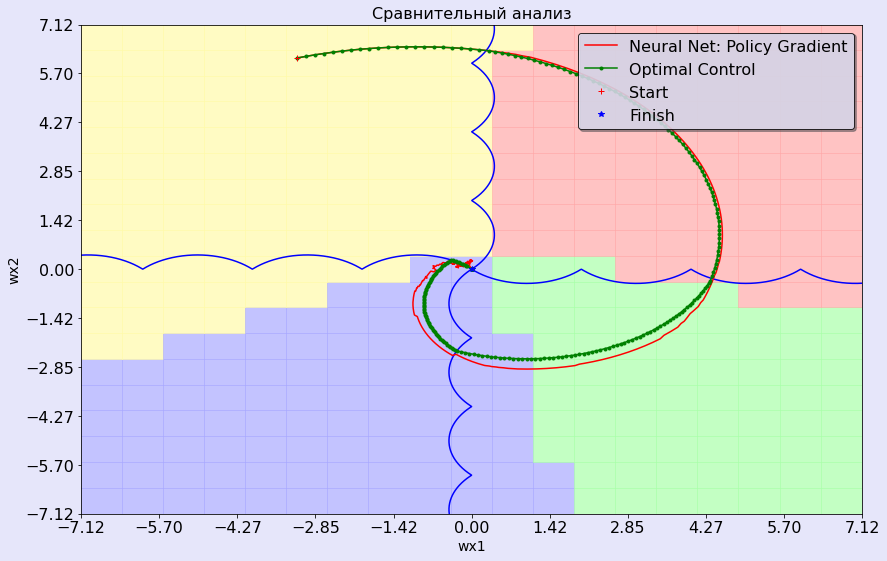

....................................................................................................
Iteration: 1800

W=9.5

Optimal Control Время: 1.4652442073678946

Neural Net Время: 1.7452908818136357

Начальная точка (+): -1.4484036801346134, 1.2072768921960986

Конечная точка (*): 0.0, 0.0

Начальное Расстояние - 1.8855743727199312

Конечное Расстояние - 0.0


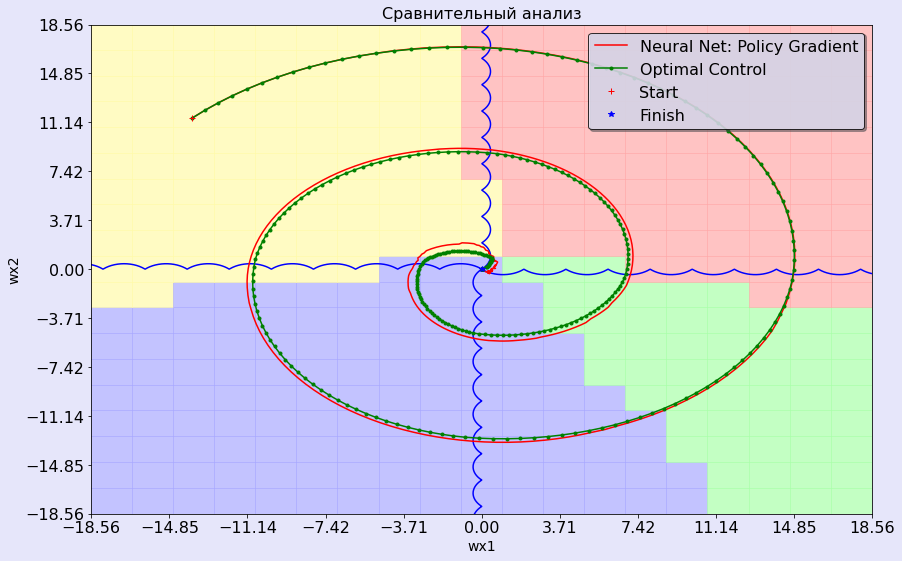

....................................................................................................
Iteration: 1900

W=4.5

Optimal Control Время: 1.1001833638939824

Neural Net Время: 1.845307551258543

Начальная точка (+): -0.44084434427631125, -1.3577462622634249

Конечная точка (*): 0.0, 0.0

Начальное Расстояние - 1.427521855724357

Конечное Расстояние - 0.0


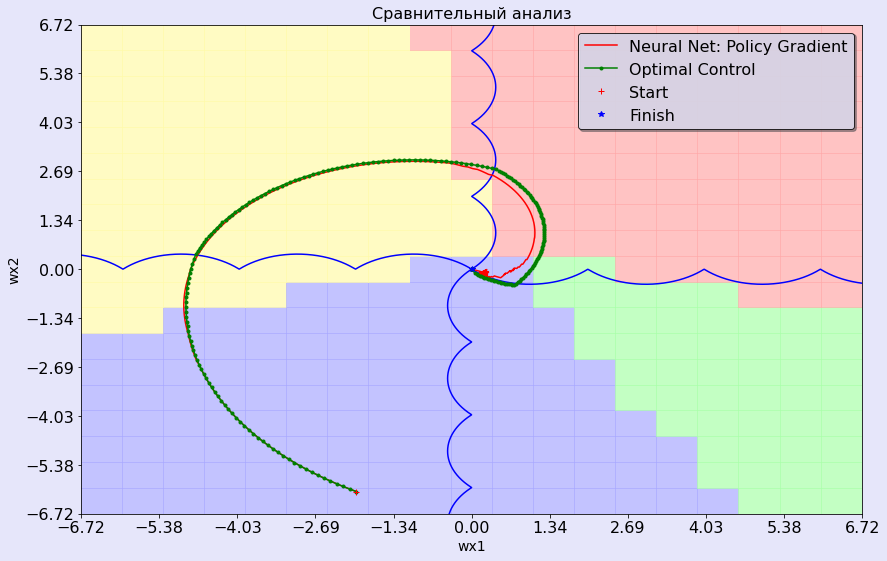

....................................................................................................
Iteration: 2000

W=7.0

Optimal Control Время: 1.710285047507918

Neural Net Время: 2.030338389731622

Начальная точка (+): -1.4492064420800346, -1.6470974429816096

Конечная точка (*): 0.0, 0.0

Начальное Расстояние - 2.1938845225860977

Конечное Расстояние - 0.0


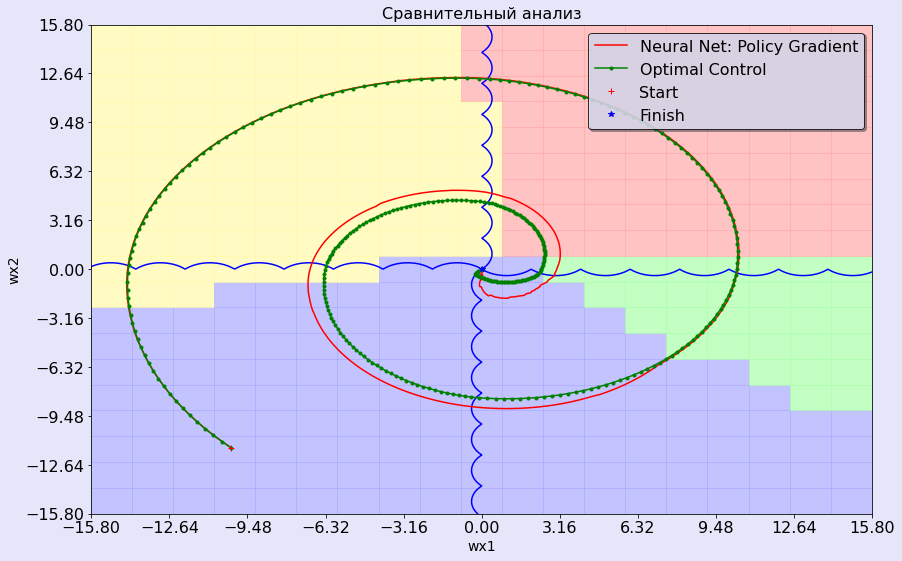

In [14]:
# Блок игр и обучения нейронной сети.
n_iterations = 2000      # Количество игр.
n_max_steps = 6000       # Максимальное количество точек на игру.
n_games_per_update = 10  # Количество игр, после которых обучаем нейронную сеть.
save_iterations = 10     # Количество игр, после которых сохраняем нейронную сеть.
discount_rate = 0.95     # Дисконтная ставка.
steps=[]                 # Список шагов.
index = 0                # Счётчик итераций.

W = np.linspace(0.5, 10, 20)           # Список возможных значений W.
Time = np.linspace(0, 30, n_max_steps) # Вектор времени.

#checkpoint_path = "./Backup/Buran_policy_net_pg2000.ckpt" # Путь к сохранённой сессии.
# Начинаем обучение нейронной сети.
with tf.Session() as sess:
    init.run() # Запускаем сессию.
    #saver.restore(sess, checkpoint_path )
    # Цикл по эпохам.
    for iteration in range(0, n_iterations+1):
        print('.', end="")
        all_rewards = []   # Вспомогательная переменная для всех наград эпохи.
        all_gradients = [] # Вспомогательная переменная для всех градиентов эпохи.
        all_cross_enropy = []
        # Цикл по играм.
        for game in range(n_games_per_update):
            current_rewards = []   # Вспомогательная переменная для всех наград игры.
            current_gradients = [] # Вспомогательная переменная для всех градиентов игры.
            
            W_INIT = random.choice(W)         # Случайная угловая скорость W.
            X_INIT = (np.random.rand()-0.5)*4 # Случайное начальное значение X1.
            Y_INIT = (np.random.rand()-0.5)*4 # Случайное начальное значение X2.
           
            # Готовим начальную инициализацию наблюдений.
            obs = np.hstack([np.array(X_INIT), np.array(Y_INIT), (X_INIT**2+Y_INIT**2)**P])
            
            # Инициализируем массивы X1, X2.
            x1 = np.zeros_like(Time)
            x2 = np.zeros_like(Time)
            x1[0] = X_INIT # Обновляем первые элементы.
            x2[0] = Y_INIT # Обновляем первые элементы.
            
            index=0
            # Цикл игры.
            for step in range(n_max_steps-1):
                # Вычисляем случайное действие агента и вычисляем градиенты.
                action_val, gradients_val, ce_val = sess.run( [action, gradients, cross_entropy], feed_dict={X: obs.reshape(1, n_inputs)})
                # Вычисляем, как отреагировала среда.
                obs, reward, done = agent_env(action_val[0][0], W_INIT, K, x1[step], x2[step], [Time[step], Time[step+1]])

                # Обновляем вектора X1, X2.
                x1[step+1] = obs[0]
                x2[step+1] = obs[1]
                
                current_rewards.append(reward)          # Сохраняем награды.
                current_gradients.append(gradients_val) # Сохранякем градиенты.
                all_cross_enropy.append(ce_val)
                
                # Если мы стабилизировали систему.
                if done:
                    steps.append(step) # Сохраняем шаг победы.
                    break              # Выходим из игры.
            
            # Сохраняем данные по игре для эпохи
            all_rewards.append(current_rewards)     # Награды.
            all_gradients.append(current_gradients) # Градиенты.
            
            # Сохраняем решение во вспомогательные массивы.
            XX = x1.copy()
            YY = x2.copy()

        # Нормализуем все награды эпохи.    
        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
        
        feed_dict = {} # Пока пустой словарь.
        # Проходимся по всем градиентам и обновляем их
        for var_index, grad_placeholder in enumerate (gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                     for game_index, rewards in enumerate(all_rewards)
                                     for step, reward in enumerate(rewards)],
                                    axis=0)
            feed_dict[grad_placeholder] = mean_gradients
        
        # Сохраняем сводку.
        CE_str = CROSS_ENTROPY.eval(feed_dict={ce_placeholder: all_cross_enropy})
        file_writer.add_summary(CE_str, iteration)
        
        # Отрисуем каждое 100 решение.
        if iteration % 100 == 0:
            print("\n\rIteration: {}".format(iteration), end="\n") # Какая итерация.
            print('\nW='+str(W_INIT))                              # Какая W.

            # Найдём максимумы.
            Xmax=np.max(np.abs(XX))         # По X1.
            Ymax=np.max(np.abs(YY))         # По X2.
            Amax = np.max([Xmax, Ymax])*1.1 # Глобальный максимум, чуть больше берём.
            
            wxx, wyy = GammaLines(W_INIT, K, Amax) # Строим гамма линии.
            xx1, xx2, opt_t = opt_solve(W_INIT, K, X_INIT, Y_INIT, Time) # Вычисляем оптимальное решение.
            
            # Выводим на экран текстовую информацию по точкам, времени и прочему.
            print(f'\nOptimal Control Время: {Time[opt_t]}')
            print(f'\nNeural Net Время: {Time[step]}')
            print(f'\nНачальная точка (+): {XX[0]}, {YY[0]}')
            print(f'\nКонечная точка (*): {XX[n_max_steps-1]}, {YY[n_max_steps-1]}')
            print(f'\nНачальное Расстояние - {(X_INIT**2+Y_INIT**2)**0.5}')
            print(f'\nКонечное Расстояние - {(XX[n_max_steps-1]**2+YY[n_max_steps-1]**2)**0.5}')
            
            # Нарисуем сферы влияния каждого типа управления.
            tick_count = 20 # Количество точек по каждой из осей.
            # Строим сетку.
            xx_mesh, yy_mesh = np.meshgrid(np.linspace(-Amax, Amax, tick_count), np.linspace(-Amax, Amax, tick_count))
            zz_mesh = xx_mesh.copy() # Создаём массив для прогноза нейронной сети.
            
            # Цикл прогноза нейронной сети.
            for nnn in range(len(xx_mesh)):
                for mmm in range(len(xx_mesh)):
                    uuu_mesh=np.hstack([xx_mesh[nnn][mmm], yy_mesh[nnn][mmm], (xx_mesh[nnn][mmm]**2+yy_mesh[nnn][mmm]**2)**P])
                    y_ppp = outputs.eval(feed_dict= {X: uuu_mesh.reshape(1, n_inputs)} )
                    zz_mesh[nnn][mmm] = np.argmax (y_ppp , axis=1 )    
            
            # Выбираем палитру для режимов управления.
            cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF', '#FFFAAA'])
            zz_mesh = zz_mesh.reshape(xx_mesh.shape) # Решейпим под общий формат.
            
            fig, ax = plt.subplots(figsize=(14,9))                                             # Строим графическое окно.
            ax.pcolormesh(W_INIT*xx_mesh, W_INIT*yy_mesh, zz_mesh, cmap=cmap_light, alpha=0.7) # Заливка по режимам.
            ax.set_xticks(np.linspace(-W_INIT*Amax, W_INIT*Amax,11));                          # Отметки по оси Х.
            ax.set_yticks(np.linspace(-W_INIT*Amax, W_INIT*Amax,11));                          # Отметки по оси Y.
            
            # Рисуем гамма линии.
            plt.plot( wxx,  wyy,'b')
            plt.plot(-wxx, -wyy,'b')
            plt.plot(-wyy,  wxx,'b')
            plt.plot( wyy, -wxx,'b')        
            
            # Рисуем начальные графики, начальные и конечные точки.
            plt.plot(W_INIT*XX, W_INIT*YY, 'r', label='Neural Net: Policy Gradient')             # График агента.
            plt.plot(W_INIT*xx1, W_INIT*xx2, 'g.-', label='Optimal Control')                     # Оптимальное управление.
            plt.plot(W_INIT*XX[0], W_INIT*YY[0], 'r+', label='Start')                            # Начальная точка.
            plt.plot(W_INIT*XX[n_max_steps - 1], W_INIT*YY[n_max_steps-1], 'b*', label='Finish') # Конечная точка.
            
            # Подписи графиков.
            plt.ylabel('wx2') # Ось X.
            plt.xlabel('wx1') # Ось Y.
            
            # Легенда, название, вывод на экран.
            plt.legend(loc='upper right')        # Положение легенды.
            ax.set_title("Сравнительный анализ") # Название графика.
            plt.show()                           # Вывод на экран.
        
        # Запускаем оптимизацию весов нейронной сети.
        sess.run(training_op, feed_dict=feed_dict)
        
        # Сохраняем параметры нейронной сети.
        if iteration % save_iterations == 0:
            saver.save(sess, "./Backup/Buran_policy_net_pg"+str(iteration)+".ckpt")      

# Закрываем журнал.
file_writer.close()

In [15]:
# Экспортируем ядро нейронной сети в файл формата HDF5.
checkpoint_path = "./Backup/Buran_policy_net_pg2000.ckpt"
with tf.Session() as sess:
    saver.restore(sess, checkpoint_path )
    with h5py.File('model.hdf5', 'w') as f:
        for var in tf.trainable_variables():
            key = var.name
            value = sess.run(var)
            f.create_dataset(key, data=value)

INFO:tensorflow:Restoring parameters from ./Backup/Buran_policy_net_pg2000.ckpt
